# Smart Optimization to Save Computing Time

<table style="width:100%; height:90%">
      <tr>
    <th>Grid Search</th>
    <th>Smart Search</th>
  </tr>
  <tr>
    <td><img src="src/07_Table_Optimize BG Default Defaults.png" alt="Optimizing Limits' Parameters" style="width:100%"></td>
    <td><img src="src/08_Table_Smart Optimization.png" alt="Parametrize the Strategy" style="width:100%"></td>
  </tr>
</table>

## Load the model

In [25]:
import pickle

In [26]:
with open('models/model_dt_regression.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [27]:
model_dt

DecisionTreeRegressor(max_depth=15)

## Load the data

In [28]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

Open        High         Low       Close    Volume  \
Date                                                                   
2016-12-08   56.325228   56.582507   55.902560   56.058762  21220800   
2016-12-09   56.214968   56.959234   56.169027   56.940857  27349400   
2016-12-12   56.803028   57.244073   56.711145   57.124622  20198100   
2016-12-13   57.427836   58.273172   57.188938   57.868881  35718900   
2016-12-14   57.887258   58.300739   57.455399   57.593227  30352700   
...                ...         ...         ...         ...       ...   
2023-03-09  255.820007  259.559998  251.580002  252.320007  26653400   
2023-03-10  251.080002  252.789993  247.600006  248.589996  28321800   
2023-03-13  247.399994  257.910004  245.729996  253.919998  33339700   
2023-03-14  256.750000  261.070007  255.860001  260.790009  33620300   
2023-03-15  259.980011  266.480011  259.209991  265.440002  46028000   

            change_tomorrow change_tomorrow_direction  
Date                                                   
2016-12-08         1.549143                        UP  
2016-12-09         0.321692                        UP  
2016-12-12         1.286112                        UP  
2016-12-13        -0.478622                      DOWN  
2016-12-14        -0.159789                      DOWN  
...                     ...                       ...  
2023-03-09        -1.500467                      DOWN  
2023-03-10         2.099087                        UP  
2023-03-13         2.634307                        UP  
2023-03-14         1.751806                        UP  
2023-03-15         3.895731                        UP  

[1576 rows x 7 columns]

## Parametrize & optimize the investment strategy

### Create Strategy class

In [29]:
from backtesting import Strategy, Backtest

In [30]:
class SimpleRegression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create `Backtest` class

In [31]:
from backtesting import Backtest

In [32]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [33]:
bt = Backtest(df_explanatory, SimpleRegression,
              cash=10000, commission=.002, exclusive_orders=True)

### Optimize backtesting with multiple combinations

In [34]:
import multiprocessing as mp
mp.set_start_method('fork')

In [39]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True
    )

Backtest.optimize:   0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

### Which are the best values for the parameters?

In [ ]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')
dff

In [ ]:
dff.style.highlight_null(props='background-color: transparent; color: transparent')

In [ ]:
import numpy as np

In [ ]:
dff.sort_index(axis=1, ascending=False)\
    .style.format(precision=0)\
    .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff))\
    .highlight_null(props='background-color: transparent; color: transparent')

### How to interpret smart optimization?

#### Number of evaluations

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

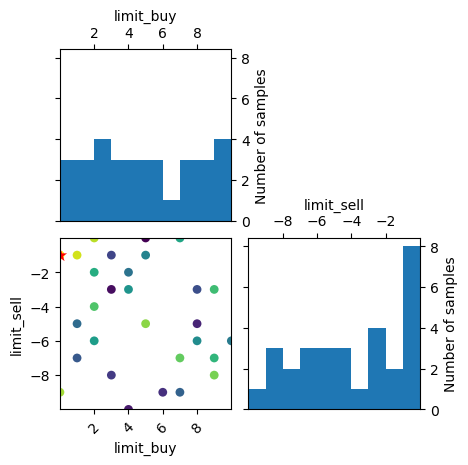

In [ ]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

#### Density

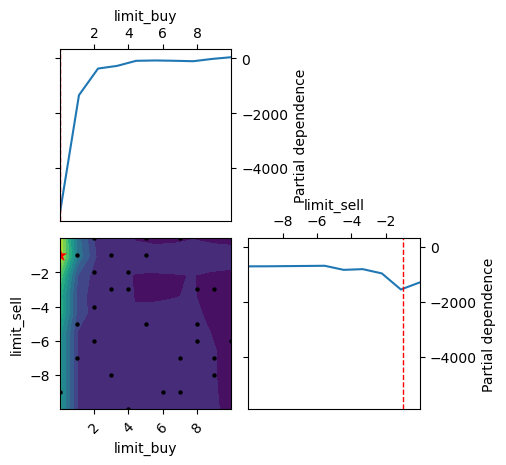

In [ ]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="08D_Smart Optimization to Save Computing Time.ipynb">notebook</a>.